In [25]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [26]:
# Se modifico con ayuda de chatgpt 
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [27]:
train_set = torchvision.datasets.CIFAR10(
    root=".", train=True, download=True, transform=transform)

test_set = torchvision.datasets.MNIST(
    root=".", train=False, download=True, transform=transform)

Files already downloaded and verified


In [28]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


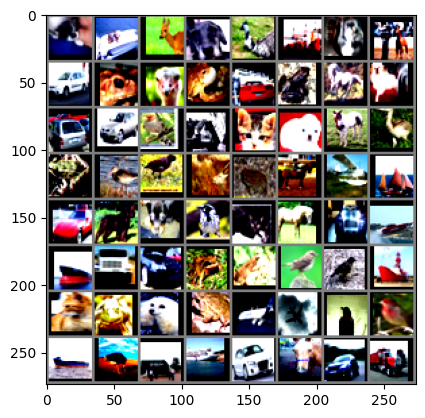

In [29]:
#Obtenido con ayuda de chatgpt 
def imshow(img):
    img = img / 2 + 0.5  # Desnormaliza
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener unas imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))

In [30]:
# Modelo
# Ref: https://blog.paperspace.com/alexnet-pytorch/ y chatgpt 
class AlexNet(nn.Module):
        def __init__(self, num_classes=10):
            super(AlexNet, self).__init__()
            self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
            self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
            self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), 256 * 6 * 6)
            x = self.classifier(x)
            return x

In [31]:
# Compilar
device = "cpu"
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005


model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)  



In [8]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # Poner a cero los gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calcular el número de predicciones correctas en este lote
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    # Calcular la pérdida promedio en esta época
    average_loss = running_loss / len(train_loader)
    
    # Calcular la precisión promedio en esta época
    accuracy = correct_predictions / total_samples
    
    print(f'Epoch: {epoch}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch: 0, Loss: 2.0707, Accuracy: 0.2160
Epoch: 1, Loss: 1.6368, Accuracy: 0.3833
Epoch: 2, Loss: 1.3877, Accuracy: 0.4851
Epoch: 3, Loss: 1.1850, Accuracy: 0.5691
Epoch: 4, Loss: 1.0263, Accuracy: 0.6299
Epoch: 5, Loss: 0.8988, Accuracy: 0.6802
Epoch: 6, Loss: 0.8104, Accuracy: 0.7148
Epoch: 7, Loss: 0.7450, Accuracy: 0.7396
Epoch: 8, Loss: 0.6812, Accuracy: 0.7624
Epoch: 9, Loss: 0.6299, Accuracy: 0.7813
Epoch: 10, Loss: 0.5837, Accuracy: 0.7951
Epoch: 11, Loss: 0.5457, Accuracy: 0.8100
Epoch: 12, Loss: 0.5138, Accuracy: 0.8215
Epoch: 13, Loss: 0.4770, Accuracy: 0.8345
Epoch: 14, Loss: 0.4514, Accuracy: 0.8432
Epoch: 15, Loss: 0.4302, Accuracy: 0.8506
Epoch: 16, Loss: 0.3983, Accuracy: 0.8626
Epoch: 17, Loss: 0.3809, Accuracy: 0.8669
Epoch: 18, Loss: 0.3568, Accuracy: 0.8771
Epoch: 19, Loss: 0.3433, Accuracy: 0.8810


In [91]:
# Establecer el modelo en el modo de evaluación
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # predicciones del modelo
        outputs = model(images)
        
        # Obtiene la clase predicha
        _, predicted = torch.max(outputs.data, 1)

        # Actualizar 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    print('Accuracy on test: {:.2f}%'.format(accuracy))

Accuracy on test: 75.21%
